In [34]:
import pyodbc as pyodbc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
 
DB_SERVER = '192.168.9.64'
#DB_SERVER = '192.168.2.71'
DB_PORT = '1433'
DB_NAME = 'ReplCS'
DB_USER = 'soporte_cierre'
DB_PASSWORD = '12345678%'

connStr = ('DRIVER={ODBC Driver 17 for SQL Server};Server=%s,%s;port=%s;Database=%s;uid=%s;pwd=%s') \
         % (DB_SERVER, DB_PORT, DB_PORT, DB_NAME, DB_USER, DB_PASSWORD)
print(connStr)
cnxn = pyodbc.connect(connStr)
cursor = cnxn.cursor()
print(cnxn, cursor)
print(cursor.execute("SELECT @@SPID").fetchone())

DRIVER={ODBC Driver 17 for SQL Server};Server=192.168.9.64,1433;port=1433;Database=ReplCS;uid=soporte_cierre;pwd=12345678%
<pyodbc.Connection object at 0x7f39620d4100> <pyodbc.Cursor object at 0x7f39645e8378>
(651, )


In [35]:
import textwrap
sql = textwrap.dedent("""
SELECT cust.name, ordr.cust_code, COUNT(1) AS tickets
FROM ordr WITH(NOLOCK)
JOIN ordl WITH(NOLOCK) ON ordr.order_code=ordl.order_code 
					  AND ordr.order_date=ordl.order_date
JOIN schd WITH(NOLOCK) ON schd.order_date = ordl.order_date	
                      AND schd.order_code = ordl.order_code 
                      AND schd.order_intrnl_line_num = ordl.order_intrnl_line_num								
JOIN schl WITH(NOLOCK) ON schd.order_date = schl.order_date 
                      AND schd.order_code = schl.order_code 
                      AND schd.order_intrnl_line_num = schl.order_intrnl_line_num	
                      AND schd.sched_num = schl.sched_num							
JOIN tick WITH(NOLOCK) ON schl.order_date = tick.order_date 
                      AND schl.order_code = tick.order_code 
                      AND schl.tkt_code = tick.tkt_code 
                      AND schl.order_intrnl_line_num = tick.rm_mix_order_intrnl_line_num 
                      AND schl.sched_num = tick.sched_num
JOIN cust WITH(NOLOCK) ON cust.cust_code = ordr.cust_code
WHERE ordr.order_date = CONVERT(DATE, GETDATE())
	AND (ordr.remove_rsn_code IS NULL OR ordr.remove_rsn_code = 'LIM')
	AND (schd.remove_rsn_code IS NULL OR schd.remove_rsn_code = 'LIM')
	AND (schl.remove_rsn_code IS NULL OR schl.remove_rsn_code = 'LIM')
	AND (tick.remove_rsn_code IS NULL OR tick.remove_rsn_code = 'LIM')
	AND (tick.reused_order_date IS NULL AND tick.reused_order_code IS NULL)
	AND (RTRIM(LTRIM(ordl.prod_code)) <> '000015' AND RTRIM(LTRIM(ordl.prod_code)) <> '000735') /* codigo de servicio bombeo Unicon y Concremax */
	AND NOT(ordr.stat = '4' AND tick.tkt_code IS NULL)	
	AND (/* Solo concreto */
		COALESCE(tick.truck_type, schd.truck_type) NOT IN ('TK','BP','BE') AND 
		COALESCE(tick.truck_type, schd.truck_type) IS NOT NULL AND 
		RTRIM(LTRIM(ordl.short_prod_descr)) <> 'PROGRAMACION DE'
	) /* Solo concreto */
GROUP BY cust.name, ordr.cust_code
ORDER BY 3 DESC
""")

In [36]:
num_list = 20
df = pd.read_sql(sql, cnxn)
df.head(num_list)

name   cust_code  tickets
0   CONSORCIO SANTA ROSA                      045271           17
1   HV CONTRATISTAS S.A.                      000091           15
2   INCOT S.A.C. CONTRATISTAS GENERALES       000702           13
3   COSAPI S.A.                               000149           11
4   CONSORCIO VIRGEN DEL CARMEN               045111            9
5   ESPARQ CIESA CONTRATISTAS GENERALES S.A.  000711            7
6   J.E. CONSTRUCCIONES GENERALES S.A.        003115            7
7   SEVILLA RODRIGUEZ S.R.L.                  004410            6
8   C Y J CONSTRUCTORES Y CONTRATISTAS S.A.C  011237            6
9   ALDESA CONSTRUCCIONES SA SUCURSAL EN PER  027495            6
10  ADESERG PERU S.A.C.                       044133            6
11  INVERSIONES ROMAYSE SAC                   027578            5
12  G Y M S.A.                                000177            4
13  OBRAS SUBTERRANEAS S.A. SUCURSAL EN LA R  034494            4
14  A Y A EDIFICACIONES S. A. C.              011064            4
15  BETON DECKEN S.A.C.                       037975            3
16  SACYR CONSTRUCCION S.A. SUCURSAL DEL PER  038463            3
17  CONSORCIO SANEAMIENTO LIMA NORTE LOTE 3   042957            3
18  CONSORCIO CESAR VALLEJO 1                 045520            3
19  SERVICIOS GENERALES JHAN MARCO E.I.R.L    008426            3

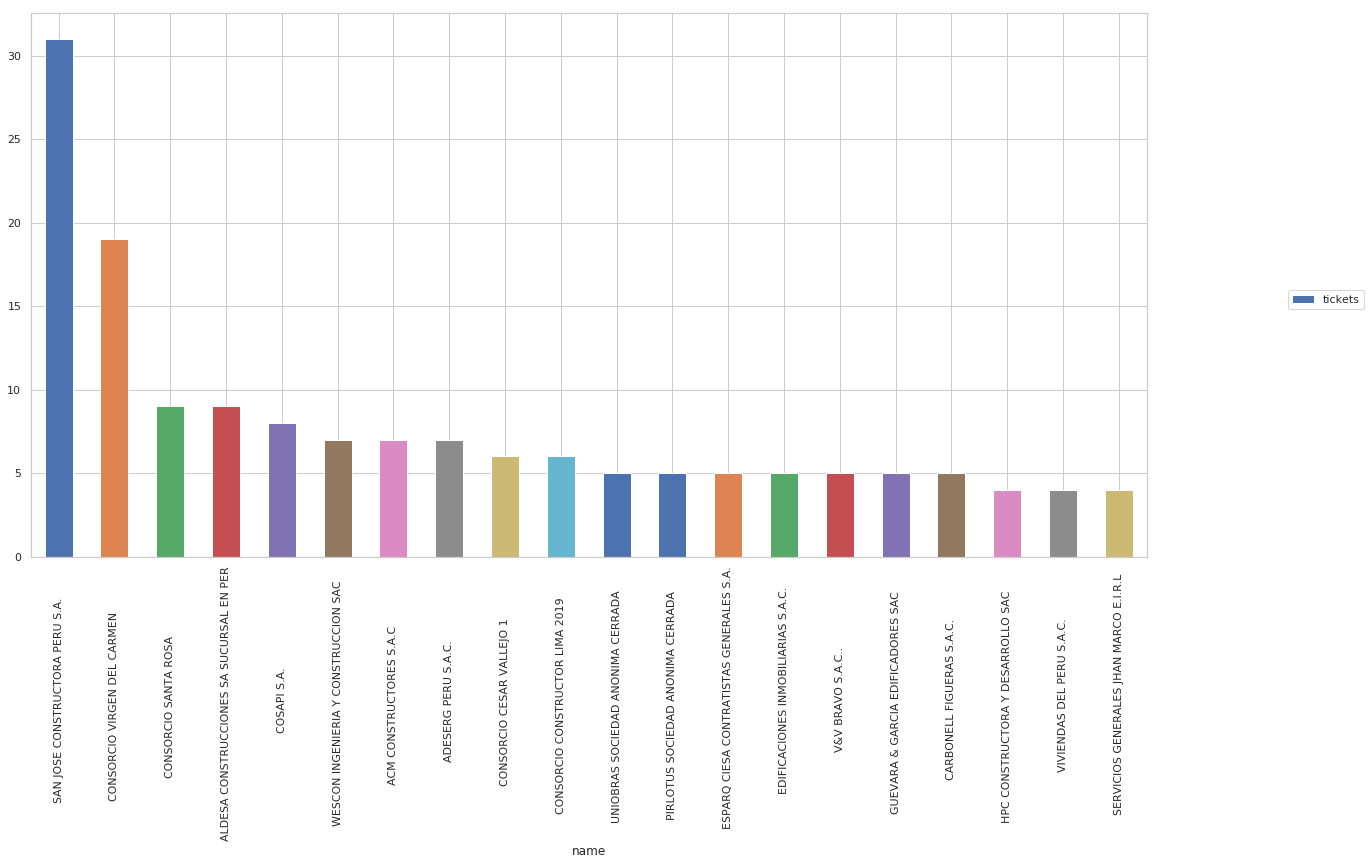

In [27]:
sns.set(style="whitegrid")
ax = df.head(num_list).plot.bar(x='name', y='tickets', rot=0, figsize=(20,10)).legend(bbox_to_anchor=(1.2, 0.5))
plt.xticks(df.head(num_list).index, df.head(num_list)['name'], rotation='vertical')
plt.show()

In [321]:
# cnxn.close()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 3 columns):
name         61 non-null object
cust_code    61 non-null object
tickets      61 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.5+ KB


In [11]:
df.describe()

tickets
count  61.000000
mean    3.672131
std     3.058983
min     1.000000
25%     2.000000
50%     3.000000
75%     4.000000
max    14.000000

In [14]:
df['tickets'].sum()

224

In [15]:
df['tickets'].mode()

0    1
1    3
dtype: int64

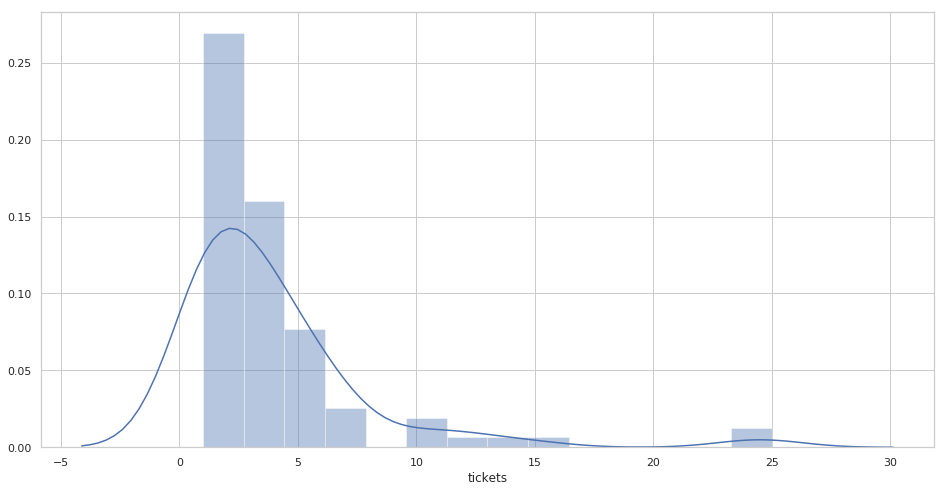

In [326]:
f, ax = plt.subplots(figsize=(16,8))
vis1 = sns.distplot(df["tickets"])

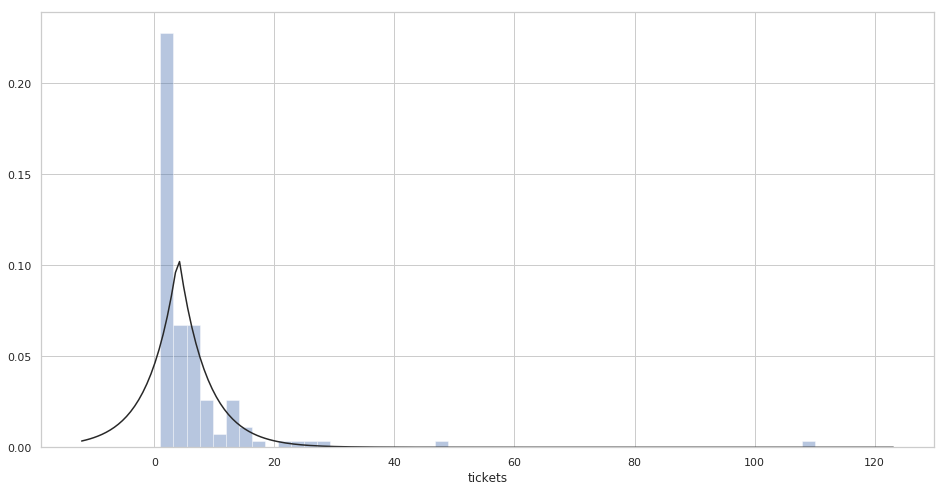

In [190]:
from scipy import stats
f, ax = plt.subplots(figsize=(16,8))
vis2 = sns.distplot(df["tickets"], fit=stats.laplace, kde=False)

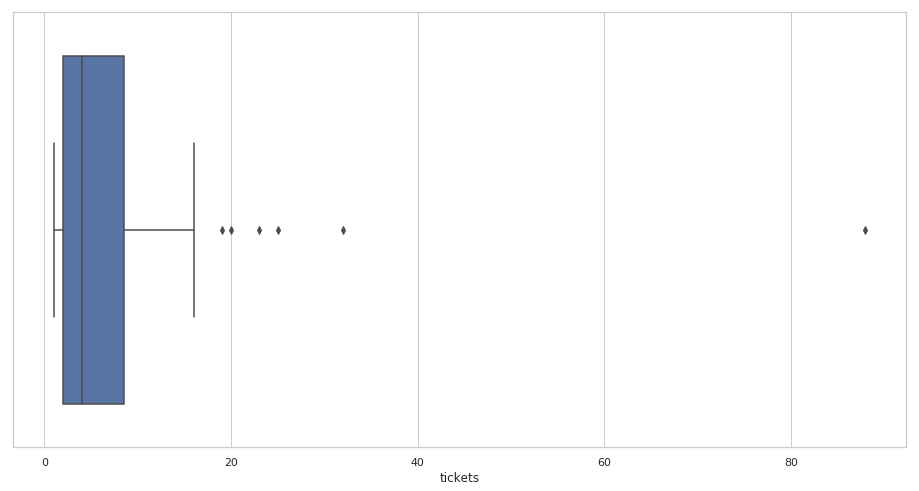

In [217]:
f, ax = plt.subplots(figsize=(16,8))
vis3 = sns.boxplot(df["tickets"], orient='h')

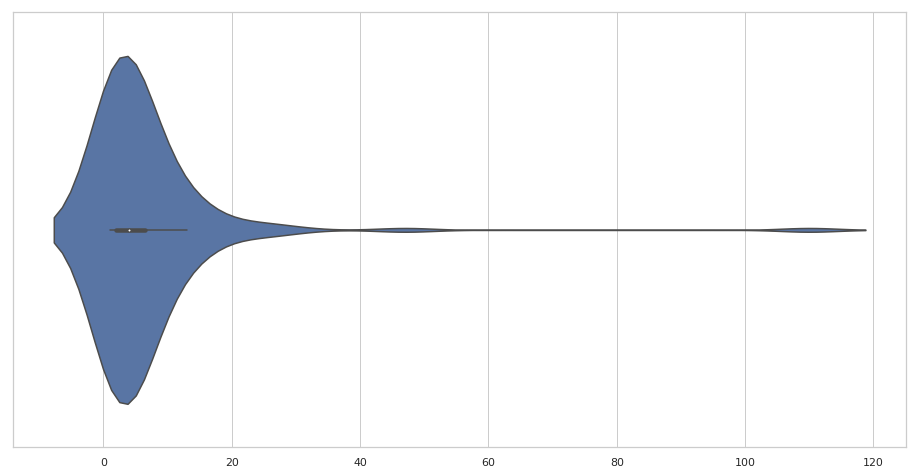

In [192]:
f, ax = plt.subplots(figsize=(16,8))
vis4 = sns.violinplot([df["tickets"]])

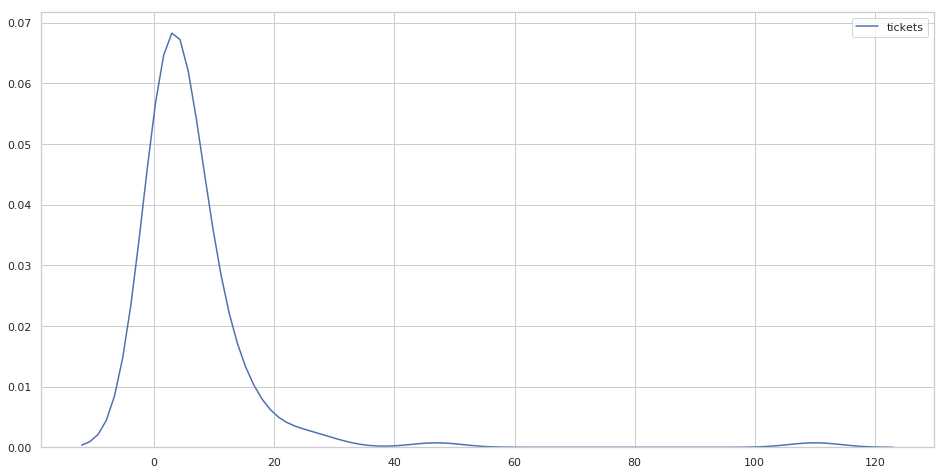

In [193]:
f, ax = plt.subplots(figsize=(16,8))
vis5 = sns.kdeplot(df.tickets)